# Logistic Regression

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.utils import resample
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score

## Load data

In [2]:
df = pd.read_csv('data/dataset.csv')
df = df[df['genre'].notnull()]
df = df.drop(['track', 'artist', 'uri'], axis=1)
df.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade,genre
1,0.498,0.505,3,-12.475,1,0.0337,0.0180,0.107000,0.1760,0.797,101.801,213613,4,48.82510,10,0,60,pop
6,0.662,0.272,0,-18.883,1,0.0313,0.3600,0.228000,0.0963,0.591,143.507,134360,4,47.82155,7,0,60,jazz
9,0.511,0.603,2,-7.637,1,0.0280,0.0385,0.000002,0.1420,0.685,128.336,157293,4,43.36534,9,1,60,pop
11,0.520,0.411,9,-12.411,1,0.0315,0.7860,0.001200,0.1460,0.350,120.290,207573,4,37.54527,9,1,60,pop
13,0.746,0.666,2,-10.408,1,0.1460,0.5430,0.000000,0.0488,0.840,94.024,192427,4,78.59848,5,1,60,country


## Scale data

In [3]:
scaler = StandardScaler()
scale_columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'chorus_hit', 'sections']
df[scale_columns] = scaler.fit_transform(df[scale_columns])
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade,genre
1,-0.436492,-0.585931,-0.627031,-0.835991,0.635356,-0.468221,-0.877471,0.089023,-0.107561,0.890630,-0.687838,-0.277328,0.203458,0.485542,-0.149679,0,60,pop
6,0.577487,-1.635045,-1.471757,-2.397885,0.635356,-0.503058,0.311075,0.621477,-0.592326,0.059415,0.814564,-1.171178,0.203458,0.431078,-0.971765,0,60,jazz
9,-0.356116,-0.144672,-0.908606,0.343230,0.635356,-0.550959,-0.806228,-0.381817,-0.314361,0.438707,0.268050,-0.912530,0.203458,0.189235,-0.423707,1,60,pop
11,-0.300470,-1.009178,1.062421,-0.820391,0.635356,-0.500155,1.791545,-0.376543,-0.290032,-0.913025,-0.021797,-0.345450,0.203458,-0.126626,-0.423707,1,60,pop
13,1.096842,0.138994,-0.908606,-0.332177,0.635356,1.161878,0.947052,-0.381824,-0.881238,1.064136,-0.967994,-0.516273,0.203458,2.101373,-1.519822,1,60,country
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41097,-1.030040,0.274073,0.780846,1.034968,-1.573921,-0.307098,-0.774603,-0.381824,2.641670,-1.409333,2.134867,0.055160,-2.950450,-0.452732,0.124350,1,10,pop
41098,0.534207,-0.014096,-0.908606,1.034237,0.635356,-0.247584,-0.874344,-0.381824,-0.738911,-0.521628,-0.028173,-0.560643,0.203458,0.632233,-0.697736,1,10,pop
41099,0.268347,0.773865,1.343996,1.519770,0.635356,-0.469672,-0.768000,-0.303936,-0.563738,-0.719344,0.113760,0.024787,0.203458,2.785570,-0.971765,1,10,pop
41103,0.929906,0.760357,1.343996,1.088104,0.635356,-0.442092,-0.894153,-0.381811,-0.332608,0.115906,-0.032280,-0.117772,0.203458,-1.039007,-0.971765,1,10,pop


## Helper functions

In [4]:
def plot_heatmap(y_test, y_pred):
    conf_matrix_nb = pd.crosstab(
        y_test,
        y_pred,
        rownames=['Actual'],
        colnames=['Predicted']
    )
    sns.heatmap(conf_matrix_nb)

## Logistic regression - "is pop"

### Original data

#### Preprocessing 

In [5]:
X = df.drop(['decade', 'genre', 'target'], axis=1)
y = df['genre'] == 'pop'
X_train, X_test, y_train, y_test = train_test_split(X, y)

#### Model

In [6]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy: 0.6450659838487296
              precision    recall  f1-score   support

       False       0.66      0.94      0.77      3263
        True       0.51      0.11      0.19      1814

    accuracy                           0.65      5077
   macro avg       0.59      0.53      0.48      5077
weighted avg       0.61      0.65      0.56      5077



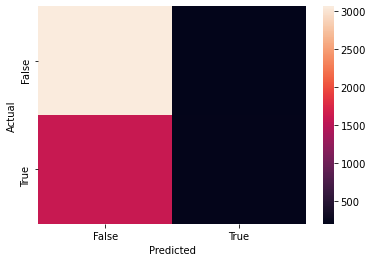

In [7]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
plot_heatmap(y_test, y_pred)

In [8]:
print(f'True: {(y_pred == True).sum()}')
print(f'False: {(y_pred == False).sum()}')

True: 404
False: 4673


#### Conclusion

The model has bad results

### Feature selection

Maybe we have too many X columns

#### Preprocessing

In [9]:
X.shape

(20307, 15)

In [10]:
feature_selection_model = LogisticRegression(solver='liblinear', random_state=0).fit(X_train, y_train)
model = SelectFromModel(feature_selection_model, prefit=True)
X_new = model.transform(X)
X_new.shape

(20307, 6)

In [11]:
y = df['genre'] == 'pop'

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y)

#### Model

In [13]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy: 0.640732716170967
              precision    recall  f1-score   support

       False       0.66      0.94      0.77      3320
        True       0.39      0.07      0.12      1757

    accuracy                           0.64      5077
   macro avg       0.53      0.51      0.45      5077
weighted avg       0.57      0.64      0.55      5077



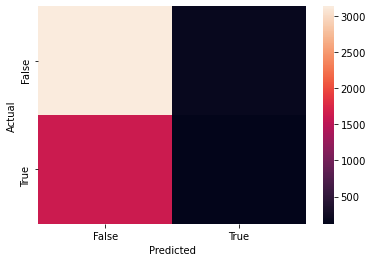

In [14]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
plot_heatmap(y_test, y_pred)

In [15]:
print(f'True: {(y_pred == True).sum()}')
print(f'False: {(y_pred == False).sum()}')

True: 315
False: 4762


#### Conclusion

No improvement

## Logistic regression - one against many

### Original data

#### Preprocessing

In [16]:
X = df.drop(['decade', 'genre', 'target'], axis=1)
genres = df.genre.unique()
Y = pd.DataFrame()
Y['genre'] = df['genre']
for genre in genres:
    Y[genre] = df['genre'] == genre
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

#### Model

In [17]:
models = {}
for genre in genres:
    models[genre] = LogisticRegression(solver='liblinear', random_state=0)
    
for genre in genres:
    y_train = Y_train[genre]
    models[genre].fit(X_train, y_train)
    
df_pred = pd.DataFrame()
for genre in genres:
    df_pred[genre] = [prob_true for prob_false, prob_true in models[genre].predict_proba(X_test)]

df_pred['max_predict'] = df_pred.idxmax(axis=1)
df_pred

,pop,jazz,country,rock,blues,funk,hip-hop,metal,techno,max_predict
0,0.500395,0.217033,0.204108,0.079701,0.123938,0.019447,0.004051,0.000005,0.000256,pop
1,0.479337,0.009875,0.043000,0.312614,0.003359,0.032853,0.027741,0.017494,0.005192,pop
2,0.360768,0.026898,0.167530,0.333558,0.015790,0.010489,0.001353,0.001205,0.000518,pop
3,0.474567,0.006417,0.296363,0.107652,0.010042,0.028433,0.380710,0.000908,0.005827,pop
4,0.506606,0.038162,0.247433,0.214095,0.039620,0.052488,0.005192,0.000173,0.000489,pop
...,...,...,...,...,...,...,...,...,...,...
5072,0.213948,0.141887,0.001565,0.118811,0.009928,0.345399,0.034608,0.004113,0.252453,funk
5073,0.432901,0.041676,0.125425,0.188746,0.054710,0.093373,0.013633,0.000057,0.000924,pop
5074,0.145432,0.092690,0.015132,0.123698,0.003990,0.003812,0.003076,0.018562,0.096091,pop
5075,0.188025,0.006357,0.051094,0.362755,0.002263,0.004657,0.023507,0.140661,0.001962,rock


In [18]:
df_pred['max_predict'].value_counts()

pop        2957
rock       1290
hip-hop     358
jazz        243
metal       174
funk         22
techno       15
country      12
blues         6
Name: max_predict, dtype: int64

In [19]:
df_pred

,pop,jazz,country,rock,blues,funk,hip-hop,metal,techno,max_predict
0,0.500395,0.217033,0.204108,0.079701,0.123938,0.019447,0.004051,0.000005,0.000256,pop
1,0.479337,0.009875,0.043000,0.312614,0.003359,0.032853,0.027741,0.017494,0.005192,pop
2,0.360768,0.026898,0.167530,0.333558,0.015790,0.010489,0.001353,0.001205,0.000518,pop
3,0.474567,0.006417,0.296363,0.107652,0.010042,0.028433,0.380710,0.000908,0.005827,pop
4,0.506606,0.038162,0.247433,0.214095,0.039620,0.052488,0.005192,0.000173,0.000489,pop
...,...,...,...,...,...,...,...,...,...,...
5072,0.213948,0.141887,0.001565,0.118811,0.009928,0.345399,0.034608,0.004113,0.252453,funk
5073,0.432901,0.041676,0.125425,0.188746,0.054710,0.093373,0.013633,0.000057,0.000924,pop
5074,0.145432,0.092690,0.015132,0.123698,0.003990,0.003812,0.003076,0.018562,0.096091,pop
5075,0.188025,0.006357,0.051094,0.362755,0.002263,0.004657,0.023507,0.140661,0.001962,rock


Accuracy: 0.4853259799093953
              precision    recall  f1-score   support

       blues       0.17      0.01      0.01       135
     country       0.58      0.01      0.03       519
        funk       0.59      0.05      0.09       254
     hip-hop       0.68      0.60      0.64       401
        jazz       0.51      0.39      0.44       315
       metal       0.79      0.55      0.65       250
         pop       0.43      0.73      0.54      1757
        rock       0.51      0.47      0.49      1402
      techno       0.47      0.16      0.24        44

    accuracy                           0.49      5077
   macro avg       0.52      0.33      0.35      5077
weighted avg       0.51      0.49      0.44      5077



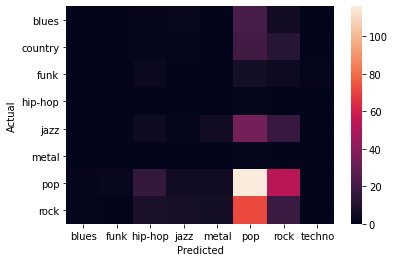

In [20]:
print(f"Accuracy: {accuracy_score(Y_test['genre'], df_pred['max_predict'])}")
print(classification_report(Y_test['genre'], df_pred['max_predict']))
plot_heatmap(Y_test['genre'], df_pred['max_predict'])

#### Conclusion 

We get really bad results for 1 against many technique with logistic regression

### Downsampled data

Let's see if downsampling the data helps

#### Preprocessing

In [21]:
df_downsampled_list = []
smallest_class_count = min(df.genre.value_counts())
for i in np.unique(df.genre):
    tmp = resample(
        df[df.genre == i],
        replace=False,
        n_samples=smallest_class_count,
        random_state=0
    )
    df_downsampled_list.append(tmp)
df_downsampled = pd.concat(df_downsampled_list)
df_downsampled = df_downsampled.sample(frac=1).reset_index(drop=True)
df_downsampled

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade,genre
0,0.738239,1.620361,0.780846,0.615977,0.635356,-0.132911,-0.934223,3.481764,1.589420,-1.683714,0.904227,0.308338,0.203458,0.719689,0.398379,0,0,techno
1,-0.999126,0.314596,-0.908606,0.177486,0.635356,-0.169200,1.127766,-0.255091,2.574764,0.511338,1.345697,0.238175,0.203458,-0.852323,2.042550,1,60,rock
2,0.274530,0.296586,-0.908606,-0.565681,0.635356,0.138530,1.645583,-0.381824,0.780465,1.564479,-0.868172,-1.233886,0.203458,-0.755789,-1.245793,1,60,country
3,2.110820,0.206533,-1.190181,-0.144740,-1.573921,1.263487,0.060855,-0.360834,1.084583,0.499233,-0.205661,-0.269501,0.203458,-0.533547,0.124350,1,90,hip-hop
4,1.121573,0.391141,-1.190181,0.049522,0.635356,-0.124201,-0.425685,-0.368799,2.878882,1.443428,-0.031451,0.042077,0.203458,0.885174,0.124350,1,70,funk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,0.404368,1.179102,1.062421,0.653269,-1.573921,-0.379676,-0.935821,3.433359,-0.363020,1.560444,-0.418345,-0.414023,0.203458,1.357484,-1.519822,1,70,funk
1454,-0.368481,-0.032107,0.217695,-0.760431,0.635356,-0.446447,-0.272772,-0.381806,-0.626995,-0.945305,-0.490933,0.587660,0.203458,-0.187944,0.672407,1,80,pop
1455,-0.009879,-0.378809,0.217695,-0.310728,0.635356,-0.481285,0.078231,-0.381824,-0.350856,-1.001796,0.091714,0.056671,0.203458,0.010924,0.124350,1,80,rock
1456,-0.059341,1.440255,1.343996,0.526524,-1.573921,4.964958,-0.936030,-0.299096,2.489611,-0.453033,1.874056,0.820740,0.203458,0.247495,1.494493,0,0,techno


In [22]:
X = df_downsampled.drop(['decade','genre','target'], axis=1)
genres = df_downsampled.genre.unique()
Y = pd.DataFrame()
Y['genre'] = df_downsampled['genre']
for genre in genres:
    Y[genre] = df_downsampled['genre'] == genre
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

#### Model

In [23]:
models = {}
for genre in genres:
    models[genre] = LogisticRegression(solver='liblinear', random_state=0)
    
for genre in genres:
    y_train = Y_train[genre]
    models[genre].fit(X_train, y_train)
    
df_downsampled_pred = pd.DataFrame()
for genre in genres:
    df_downsampled_pred[genre] = [prob_true for prob_false, prob_true in models[genre].predict_proba(X_test)]

df_downsampled_pred['max_predict'] = df_downsampled_pred.idxmax(axis=1)
df_downsampled_pred

,techno,rock,country,hip-hop,funk,pop,metal,jazz,blues,max_predict
0,0.152451,0.264685,0.182224,0.016046,0.110498,0.161638,0.084121,0.014533,0.015770,rock
1,0.153910,0.063644,0.010720,0.080277,0.544655,0.107798,0.011297,0.071375,0.023827,funk
2,0.026365,0.189335,0.099750,0.010552,0.388567,0.152397,0.007570,0.062003,0.108101,funk
3,0.015892,0.136759,0.367624,0.007103,0.010647,0.139866,0.051233,0.054798,0.056843,country
4,0.040915,0.039229,0.115176,0.004928,0.005625,0.076679,0.004391,0.101112,0.046525,country
...,...,...,...,...,...,...,...,...,...,...
360,0.072354,0.176848,0.223967,0.072096,0.063472,0.163063,0.068124,0.010066,0.017184,country
361,0.071086,0.124280,0.033919,0.037334,0.513054,0.166157,0.007587,0.067500,0.039110,funk
362,0.006247,0.056741,0.000552,0.004943,0.226281,0.034318,0.112992,0.024677,0.412701,blues
363,0.000686,0.113121,0.317857,0.023318,0.042533,0.178334,0.002508,0.120194,0.350588,blues


In [24]:
df_downsampled_pred['max_predict'].value_counts()

country    54
funk       54
metal      50
hip-hop    45
blues      44
techno     44
jazz       33
rock       32
pop         9
Name: max_predict, dtype: int64

Accuracy: 0.4931506849315068
              precision    recall  f1-score   support

       blues       0.30      0.43      0.35        30
     country       0.44      0.63      0.52        38
        funk       0.33      0.53      0.41        34
     hip-hop       0.73      0.72      0.73        46
        jazz       0.42      0.39      0.41        36
       metal       0.68      0.87      0.76        39
         pop       0.11      0.02      0.04        48
        rock       0.38      0.24      0.30        49
      techno       0.70      0.69      0.70        45

    accuracy                           0.49       365
   macro avg       0.46      0.50      0.47       365
weighted avg       0.46      0.49      0.46       365



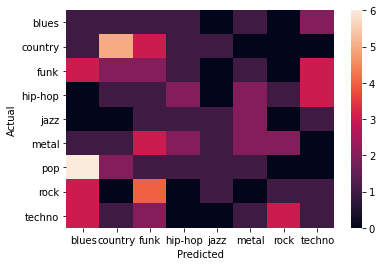

In [25]:
print(f"Accuracy: {accuracy_score(Y_test['genre'], df_downsampled_pred['max_predict'])}")
print(classification_report(Y_test['genre'], df_downsampled_pred['max_predict']))
plot_heatmap(Y_test['genre'], df_downsampled_pred['max_predict'])

#### Conclusion

Downsampling the classes to the same count doesn't improve the performance

## LDA visualisation

In [26]:
X = df.drop(['decade','genre','target'], axis=1)
Y = df['genre']

In [27]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda_red = lda.fit(X, Y).transform(X)

<AxesSubplot:>

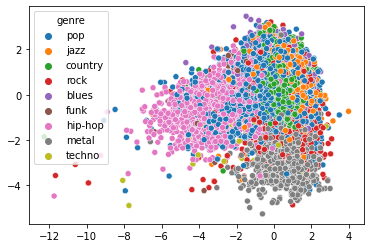

In [28]:
sns.scatterplot(x=lda_red[:,0], y=lda_red[:,1], hue=df['genre'])

## LDA prediction

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,df['genre'])

In [30]:
lda_predictions=LinearDiscriminantAnalysis(n_components=2)
lda_predictions.fit(X_train,y_train)

LinearDiscriminantAnalysis(n_components=2)

In [31]:
y_pred = lda_predictions.predict(X_test)

0.4794169785306283
              precision    recall  f1-score   support

       blues       0.14      0.06      0.08       147
     country       0.19      0.02      0.03       521
        funk       0.41      0.09      0.14       256
     hip-hop       0.64      0.59      0.61       393
        jazz       0.50      0.40      0.44       341
       metal       0.63      0.61      0.62       226
         pop       0.45      0.70      0.55      1802
        rock       0.52      0.45      0.48      1354
      techno       0.16      0.38      0.22        37

    accuracy                           0.48      5077
   macro avg       0.40      0.37      0.35      5077
weighted avg       0.46      0.48      0.44      5077



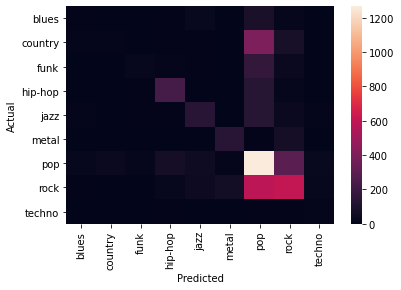

In [32]:
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_heatmap(y_test, y_pred)

## QDA prediction

In [33]:
qda_predictions = QuadraticDiscriminantAnalysis()
qda_predictions.fit(X_train,y_train)

QuadraticDiscriminantAnalysis()

In [34]:
y_pred = qda_predictions.predict(X_test)

0.4193421311798306
              precision    recall  f1-score   support

       blues       0.13      0.10      0.12       147
     country       0.25      0.72      0.37       521
        funk       0.31      0.21      0.25       256
     hip-hop       0.62      0.68      0.65       393
        jazz       0.44      0.43      0.44       341
       metal       0.55      0.64      0.59       226
         pop       0.47      0.37      0.41      1802
        rock       0.57      0.33      0.41      1354
      techno       0.24      0.30      0.27        37

    accuracy                           0.42      5077
   macro avg       0.40      0.42      0.39      5077
weighted avg       0.47      0.42      0.42      5077



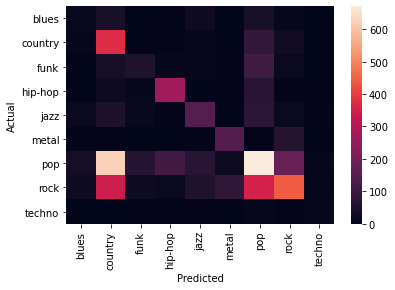

In [35]:
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_heatmap(y_test, y_pred)

## Ensemble methods

### Preprocessing

In [36]:
X = df.drop(['decade', 'genre', 'target'],axis=1)
le = LabelEncoder()
y = le.fit_transform(df['genre'])
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Separate performance

In [37]:
model_lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_dt = DecisionTreeClassifier()
model_knn = KNeighborsClassifier()

model_lr.fit(X_train, y_train)
model_dt.fit(X_train, y_train)
model_knn.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)
y_pred_dt = model_dt.predict(X_test)
y_pred_knn = model_knn.predict(X_test)

In [38]:
print(f'LogisticRegression accuracy {accuracy_score(y_test, y_pred_lr)}')
print(f'DecisionTree accuracy {accuracy_score(y_test, y_pred_dt)}')
print(f'KNeighborsClassifier accuracy {accuracy_score(y_test, y_pred_knn)}')

LogisticRegression accuracy 0.4896592475871578
DecisionTree accuracy 0.41796336419145164
KNeighborsClassifier accuracy 0.4400236360055151


### Voting classifier

In [39]:
voting_clf = VotingClassifier(estimators=[('KNN', model_knn),('DTree', model_dt),('LogReg', model_lr)], voting='hard')
voting_clf.fit(X_train, y_train)
predic=voting_clf.predict(X_test)
acc=accuracy_score(y_test, predic)
f1=f1_score(y_test, predic, average='macro')
print(f'Accuracy score: {acc}')
print(f'F1 score: {f1}')

Accuracy score: 0.4794169785306283
F1 score: 0.3926461374371441


### Bagging classifier

In [40]:
model_lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_dt = DecisionTreeClassifier()
model_knn = KNeighborsClassifier()

model_bagging_lr = BaggingClassifier(base_estimator=model_lr, n_estimators=5)
model_bagging_dt = BaggingClassifier(base_estimator=model_dt, n_estimators=5)
model_bagging_knn = BaggingClassifier(base_estimator=model_knn, n_estimators=5)

In [41]:
def ensemble_cross_val(model, n_splits):
    k_folds = KFold(n_splits=n_splits)
    results = cross_val_score(model, X_train, y_train, cv=k_folds)
    print(results.mean())

In [42]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
print('Logistic regression cross val score: ')
ensemble_cross_val(model_bagging_lr, 20)
print(f'Decision tree cross val score: ')
ensemble_cross_val(model_bagging_dt, 20)
print(f'KNN cross val score: ')
ensemble_cross_val(model_bagging_knn, 20)

Logistic regression cross val score: 
0.4985584136082858
Decision tree cross val score: 
0.46789458889912083
KNN cross val score: 
0.4479358731604016


### AdaBoost classifier

In [44]:
model = AdaBoostClassifier(n_estimators=10)
ensemble_cross_val(model, 10)

0.45351280367695335
